<a href="https://colab.research.google.com/github/RaymundoDLC/MachineLearning/blob/main/%C3%81rbol_de_Decisi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Mejores Hiperparámetros (Árbol de Decisión): {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5}

  REPORTE DE CLASIFICACIÓN (ÁRBOL DE DECISIÓN OPTIMIZADO)
               precision    recall  f1-score   support

No Pagado (0)       0.19      0.58      0.29       882
   Pagado (1)       0.89      0.58      0.70      5085

     accuracy                           0.58      5967
    macro avg       0.54      0.58      0.50      5967
 weighted avg       0.79      0.58      0.64      5967

Matriz de Confusión:
 [[ 513  369]
 [2134 2951]]

Recall de la Clase 'No Pagado' (0): 0.5816 (Objetivo de Negocio)
--------------------------------------------------
Área Bajo la Curva (AUC): 0.6031


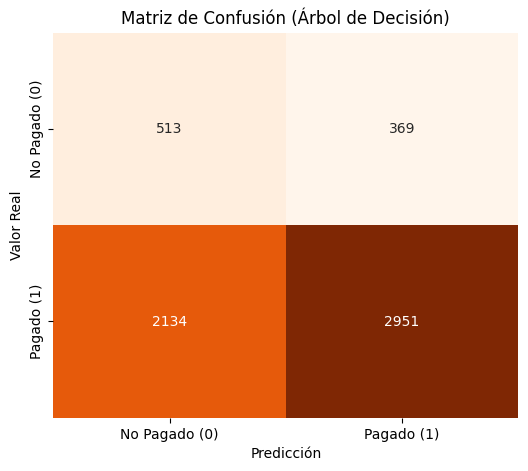

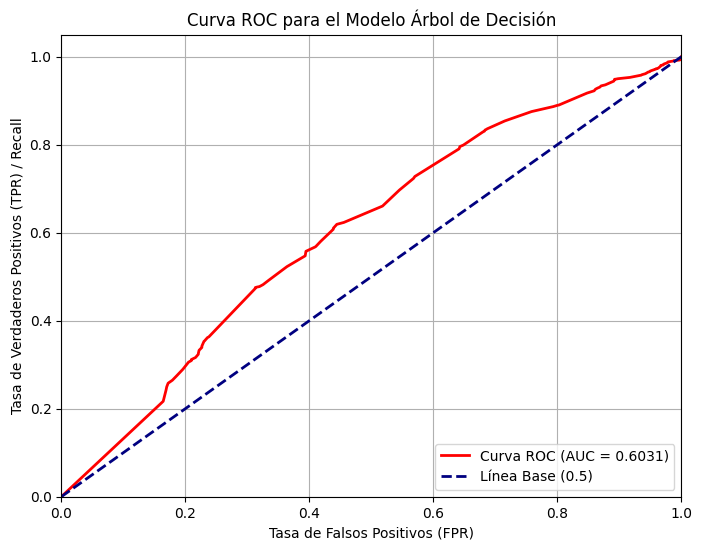

In [1]:
# ==============================================================================
# PROYECTO INTEGRADOR: MODELO ÁRBOL DE DECISIÓN (DECISION TREE)
# ==============================================================================

# --- 1. CONFIGURACIÓN E IMPORTACIONES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier # Modelo clave
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    roc_curve,
    roc_auc_score
)

# Configuración de visualización
pd.set_option('display.max_columns', None)

# --- 2. CARGA Y PREPROCESAMIENTO DE DATOS (REUSO DE LA PARTE 1) ---

# *NOTA: Asumimos que el archivo .csv ha sido subido.*
try:
    df = pd.read_csv('lending_club_2007_2011_6_states (1).csv')
except FileNotFoundError:
    print("Error: Asegúrate de subir el archivo CSV al entorno de Colab.")
    exit()

# 2.1 Limpieza y creación de la variable objetivo
df['repaid'] = df['loan_status'].apply(lambda status: 1 if status in ['Fully Paid'] else 0)

# 2.2 Selección, limpieza y Codificación
feature_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'purpose', 'grade', 'home_ownership', 'verification_status'
]
df_clean = df[df.columns.intersection(feature_cols + ['repaid'])].copy()
df_clean.dropna(inplace=True)

# Codificación One-Hot
df_dummies = pd.get_dummies(df_clean, columns=['purpose', 'home_ownership', 'verification_status'], drop_first=True)

# Codificación Ordinal de 'grade'
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df_dummies['grade_code'] = df_dummies['grade'].map(grade_mapping)
df_dummies.drop('grade', axis=1, inplace=True)

# Definición final de X e Y
X = df_dummies.drop('repaid', axis=1)
y = df_dummies['repaid']

# 2.3 División y Escalamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# NOTA IMPORTANTE: Los Árboles de Decisión NO requieren escalamiento.
# Sin embargo, mantenemos los datos escalados (X_train_scaled) para facilitar la comparación
# y la reutilización del código en todos los modelos (incluyendo SVM y RF que vienen después).

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 3. ENTRENAMIENTO Y OPTIMIZACIÓN DEL MODELO ÁRBOL DE DECISIÓN (PARTE 2) ---

# 3.1 Definición del espacio de hiperparámetros para GridSearch
param_grid = {
    'max_depth': [3, 5, 8, 10], # Controla el sobreajuste (overfitting)
    'min_samples_split': [5, 10, 20], # Número mínimo de muestras requeridas para dividir un nodo
    'class_weight': ['balanced'] # Ajuste para el desbalance de clases, priorizando la clase minoritaria (0)
}

dtree = DecisionTreeClassifier(random_state=42)

# 3.2 Búsqueda de hiperparámetros (GridSearchCV)
# Se optimizará utilizando 'recall' ya que el objetivo es maximizar la detección de impagos (Clase 0).
grid_search = GridSearchCV(
    dtree,
    param_grid,
    cv=5,
    scoring='recall', # El scoring se basa en el recall de la clase positiva por defecto (Clase 1),
                      # pero al usar class_weight='balanced', se impulsa el recall de ambas.
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# 3.3 Selección del mejor modelo y predicciones
dtree_best = grid_search.best_estimator_
print(f"\nMejores Hiperparámetros (Árbol de Decisión): {grid_search.best_params_}")

y_pred = dtree_best.predict(X_test_scaled)
y_proba = dtree_best.predict_proba(X_test_scaled)[:, 1] # Probabilidad de la Clase 1 (Pagado)


# --- 4. EVALUACIÓN Y GRÁFICOS (PARTE 3) ---

print("\n" + "="*50)
print("  REPORTE DE CLASIFICACIÓN (ÁRBOL DE DECISIÓN OPTIMIZADO)")
print("="*50)

# 4.1 Reporte de Clasificación y Matriz de Confusión
print(classification_report(y_test, y_pred, target_names=['No Pagado (0)', 'Pagado (1)']))
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:\n", cm)

# Métrica de Negocio Clave
recall_clase_0 = recall_score(y_test, y_pred, pos_label=0)
print(f"\nRecall de la Clase 'No Pagado' (0): {recall_clase_0:.4f} (Objetivo de Negocio)")
print("-" * 50)

# 4.2 Métricas ROC y AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"Área Bajo la Curva (AUC): {auc_score:.4f}")

# 4.3 Gráfico de la Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['No Pagado (0)', 'Pagado (1)'],
            yticklabels=['No Pagado (0)', 'Pagado (1)'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión (Árbol de Decisión)')
plt.show()

# 4.4 Generación del Gráfico de Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Línea Base (0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC para el Modelo Árbol de Decisión')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()